## Importing relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Algos
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Reading data

In [3]:
raw_data = pd.read_csv('data.csv')
raw_data = raw_data.sample(frac=1, random_state=42, ignore_index=1)

to_standarize = raw_data[['minutes', 'nbr_days']]
inputs_2 = raw_data[['quiz', 'exam', 'q&a']]
targets = raw_data[['subscribed']]

scaler = StandardScaler()
scaler.fit(to_standarize)
standarized = pd.DataFrame(scaler.transform(to_standarize), columns = ['minutes', 'nbr_days'])

inputs = standarized.join(inputs_2)

inputs.head().join(targets)

,minutes,nbr_days,quiz,exam,q&a,subscribed
0,-0.183098,-0.275298,0,0,0,0
1,-0.183098,-0.275298,0,0,0,0
2,-0.003467,0.021431,1,0,0,0
3,-0.183098,-0.275298,0,0,0,0
4,-0.182398,-0.126933,0,0,0,0


## Data splitting

In [4]:
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

print(X_train_imbalanced.shape, X_test.shape, y_train_imbalanced.shape, y_test.shape)

(28184, 5) (7046, 5) (28184, 1) (7046, 1)


## OverSampling using SMOTE

 As we can see our data is imbalance so we will try to balance it using an over-sampling method called SMOTE

<BarContainer object of 2 artists>

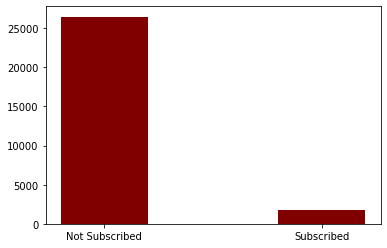

In [5]:
plt.bar(["Not Subscribed", "Subscribed"], list(y_train_imbalanced.value_counts()), color='maroon', width=0.4)

In [6]:
smote = SMOTE(sampling_strategy = 'auto',random_state=101)
X_train, y_train = smote.fit_resample(X_train_imbalanced, y_train_imbalanced)

print(X_train.shape, y_train.shape)

(52912, 5) (52912, 1)


<BarContainer object of 2 artists>

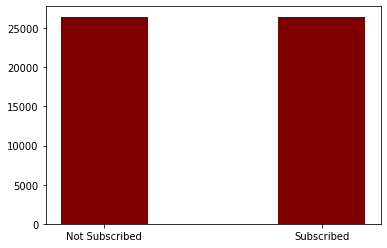

In [7]:
plt.bar(["Not Subscribed", "Subscribed"], list(y_train.value_counts()), color='maroon', width=0.4)

# UnderSampling the OverSampled data

In general, for a better dataset and to increase the model's performance we apply under-sampling after over-sampling an imbalanced dataset

In [8]:
undersampler = RandomUnderSampler(sampling_strategy = 'auto',random_state=101)

X_train, y_train = undersampler.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)

(52912, 5) (52912, 1)


<BarContainer object of 2 artists>

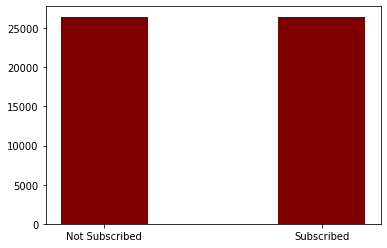

In [9]:
plt.bar(["Not Subscribed", "Subscribed"], list(y_train.value_counts()), color='maroon', width=0.4)

# Model

In [10]:
X_train, y_train = np.array(X_train), np.ravel(np.array(y_train))

print(X_train.shape)
print(y_train.shape)

X_test, y_test = np.array(X_test), np.ravel(np.array(y_test))

print(X_test.shape)
print(y_test.shape)

(52912, 5)
(52912,)
(7046, 5)
(7046,)


In [11]:
modelSVC = svm.SVC(gamma = 'auto')
modelSVC.fit(X_train, y_train)

SVC(gamma='auto')

In [12]:
y_predicted = modelSVC.predict(X_test)
print(accuracy_score(y_test, y_predicted), recall_score(y_test, y_predicted), precision_score(y_test, y_predicted))

0.9202384331535624 0.8501228501228502 0.4085005903187721


# Training multiple models

In [13]:
multipleModels = {'LogisticRegression': LogisticRegression(),
                   'DecisionTreeClassifier': DecisionTreeClassifier(),
                   'RandomForestClassifier': RandomForestClassifier(),
                   'GaussianNB': GaussianNB(),
                   'KNeighborsClassifier': KNeighborsClassifier()}

In [14]:
scores = []
for name, model in multipleModels.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append({
        'name': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    })

In [15]:
pd.DataFrame(scores)

,name,accuracy,recall,precision,f1
0,LogisticRegression,0.922225,0.847666,0.415162,0.557351
1,DecisionTreeClassifier,0.934573,0.756757,0.459701,0.571959
2,RandomForestClassifier,0.934147,0.781327,0.458874,0.578182
3,GaussianNB,0.935992,0.788698,0.467930,0.587374
4,KNeighborsClassifier,0.923787,0.828010,0.419154,0.556565


From these values we can see that all our models are good at predicting negatives (recall score) and bad at predicting positives (precision score)

However, Best accuracy is Naive Bayes Model

In [16]:
nbModel = GaussianNB()
nbModel.fit(X_train, y_train)
y_nb_pred = nbModel.predict(X_test)

In [19]:
print(classification_report(y_test, y_nb_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6639
           1       0.47      0.79      0.59       407

    accuracy                           0.94      7046
   macro avg       0.73      0.87      0.78      7046
weighted avg       0.96      0.94      0.94      7046



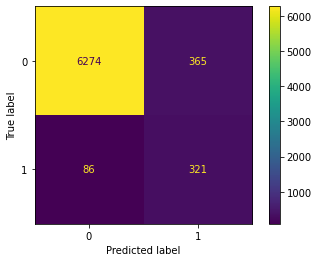

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_nb_pred)

As we can see again, our model is good at predicting 0 values (not subscribed) but not so much in predicting 1 values (subscribed), this is because of our unbalanced dataset and test set

# Conclusion

In the end, our over sampling method didn't solve all the problems.
We have a very unbalanced dataset, for example USA represents more than 40% of our data (minutes watched) and many other unbalanced features that prevent our model to learn correctly especially those 1 values.
we can try a different approach such as neural networks but it might face the same problem as our data is hugely unbalanced.